# Homework 05 - Francesco Ortu

In [3]:
import os
import sys
import json
import numpy as np
import torch
torch.set_default_dtype(torch.float64) 
import sklearn
from sklearn.datasets import make_circles
from sklearn.gaussian_process import GaussianProcessClassifier
import sklearn.gaussian_process as gp_sklearn 
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, HMC, NUTS
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO
from pyro.contrib.autoguide import AutoDiagonalNormal
from pyro.optim import Adam
import pyro.contrib.gp as gp 
import matplotlib.pyplot as plt
import seaborn as sns

Let's consider a binary classification problem on Circles dataset. The input is two-dimensional and the response is binary(0,1).

We observe 100  points $x$ from this dataset and their labels $y$ :

/home/francesco/anaconda3/envs/deep_le/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


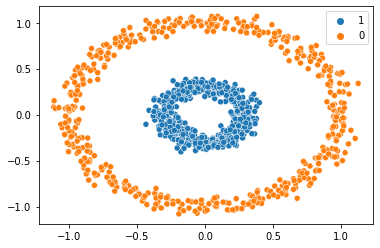

In [4]:
x, y = make_circles(n_samples=1000, factor=0.3, noise=0.05, random_state=0)
x = torch.from_numpy(x)
y = torch.from_numpy(y).double() 
def scatterplot(x, y):    
    colors = np.array(['0', '1'])    
    sns.scatterplot(x[:, 0], x[:, 1], hue=colors[y.int()])
scatterplot(x, y)

## 1 
 GaussianProcessClassifier  from scikit-learn library approximates the non-Gaussian posterior by a Gaussian using Laplace approximation.
  Define an RBF kernel   `gp_sklearn.kernels.RBF` with lenghtscaleparameter = 1   and fit a Gaussian Process classifier to the observed data $(x,y)$:

In [5]:
kernel = gp_sklearn.kernels.RBF(length_scale=1.0)
gpc = gp_sklearn.GaussianProcessClassifier(kernel=kernel).fit(x, y)

## 2

Use  `plot_sklearn_predictions`  function defined below to plot the posterior predictive mean function over afinite grid of points. You should pass as inputs the learned GP classifier  `sklearn_gp_classifier` , the observedpoints  x  and their labels  y

In [6]:
def meshgrid(x, n, eps=0.1):
 x0, x1 = np.meshgrid(np.linspace(x[:, 0].min()-eps, x[:, 0].max()+eps, n),
 np.linspace(x[:, 1].min()-eps, x[:, 1].max()+eps, n))
 x_grid = np.stack([x0.ravel(), x1.ravel()], axis=-1)
 return x0, x1, x_grid
 
def plot_sklearn_predictions(sklearn_gp_classifier, x, y):
 x0, x1, x_grid = meshgrid(x, 30)
 preds = sklearn_gp_classifier.predict_proba(x_grid)
 preds_0 = preds[:,0].reshape(x0.shape)
 preds_1 = preds[:,1].reshape(x0.shape)
 plt.figure(figsize=(10,6))
 plt.contourf(x0, x1, preds_0, 101, cmap=plt.get_cmap('bwr'), vmin=0, vmax=1)
 plt.contourf(x0, x1, preds_1, 101, cmap=plt.get_cmap('bwr'), vmin=0, vmax=1)
 plt.title(f'Posterior Mean')
 plt.xticks([]); plt.yticks([])
 plt.colorbar()
 scatterplot(x, y)

/home/francesco/anaconda3/envs/deep_le/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


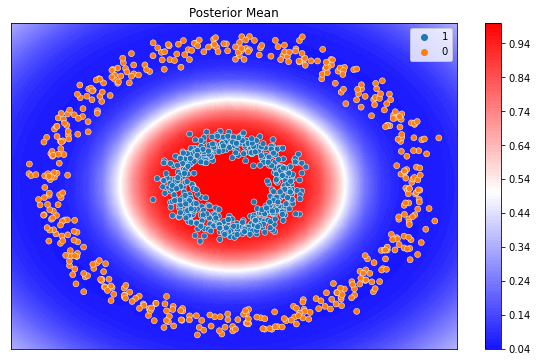

In [7]:
plot_sklearn_predictions(gpc, x,y)

----
----

Consider the following generative model:
$$ y_n | p_n \sim Bernoulli(p_n) \quad n = 1, \dots, N $$
$$ u \sim N(0,1) $$
$$ \sigma, l \sim LogNormal(0,1) $$
$$ logit(\textbf{p}) | u, \sigma, l \sim \mathcal{GP}(i, K_{\sigma,l}(x_n)) $$

We model the binary response variable with a Bernoulli likelihood. The logit of the probability is a Gaussian Process with predictors $x_n$ and kernel matrix $K_{\sigma,l}$, parametrized by variance $\sigma$ and lengthscale $l$.


We want to solve this binary classification problem by means of HMC inference, so we need to reparametrize the multivariate Gaussian $\mathcal{GP}(i, K_{\sigma,l}(x_n))$ in order to ensure computational efficiency. Specifically, we model the logit probability as
$$
logit(\textbf{p}) = \mu \textbf{1}_N + \eta L
$$

where $L$ is the Cholesky factor of $\mathcal{GP}(i, K_{\sigma,l}(x_n))$ and $\eta_n \sim N(0,1)$. This relationship is implemented by the get_logits
function below.

In [8]:
def get_logits(x, mu, sigma, l, eta):
 kernel = gp.kernels.RBF(input_dim=2, variance=sigma.clone().detach() , lengthscale=l.clone().detach())
 K = kernel.forward(x, x) + torch.eye(x.shape[0]) * 1e-6
 L = K.cholesky()
 return mu+torch.mv(L,eta)

## 3
Write a pyro model `gp_classifier(x,y)` that implements the reparametrized generative model, using
`get_logits` function and `pyro.plate` on independent observations $y_n$


In [11]:
def gp_classifier(x,y):
    N = x.shape[0]

    mu = pyro.sample('mu',dist.Normal(0,1))
    sigma = pyro.sample('sigma',dist.LogNormal(0,1))
    l = pyro.sample('l',dist.LogNormal(0,1))

    with pyro.plate('logit', N):
        eta = pyro.sample('eta',dist.Normal(0,1))
        logit_p = get_logits(x, mu, sigma, l, eta)
        y_ = pyro.sample('obs', dist.Bernoulli(torch.sigmoid(logit_p) ), obs=y)
    
    return y_, logit_p


## 4
Use pyro `NUTS` on the `gp_classifier` model to infer the posterior distribution of its parameters. Set
num_samples=10 and warmup_steps=50 . Then extract the posterior samples using pyro `.get_samples()`
and print the keys of this dictionary using `.keys()` method.

In [13]:
kernel = NUTS(gp_classifier)
mcmc = MCMC(kernel, num_samples=10, warmup_steps=50)
# mcmc.run(x,y)
# mcmc_samples = mcmc.get_samples()

mcmc_samples = torch.load('mcmc_samples.pt')

# torch.save(mcmc.get_samples(), 'mcmc_samples.pt')

In [14]:
print(mcmc_samples)
print(mcmc_samples.keys())


{'eta_n': tensor([[ 3.3385,  3.3839, -1.3453,  ..., -0.7741, -0.5634, -0.6234],
        [ 3.4404,  3.3368, -1.5220,  ..., -0.8839, -0.5494, -0.8186],
        [ 3.3516,  3.1848, -1.5146,  ..., -1.1048, -0.5730, -0.6491],
        ...,
        [ 2.8897,  3.2781, -0.6440,  ..., -1.1041, -0.3994, -1.5165],
        [ 2.9248,  3.4070, -0.5784,  ..., -1.1872, -0.3087, -1.6630],
        [ 2.7743,  3.1132, -0.7908,  ..., -1.0131, -0.2059, -1.6089]]), 'l': tensor([0.4315, 0.4144, 0.3823, 0.3676, 0.3514, 0.3547, 0.3366, 0.3329, 0.3514,
        0.3687]), 'mu': tensor([-2.0585, -1.9622, -1.8864, -2.2572, -2.1211, -2.1927, -1.9200, -1.8586,
        -1.9987, -2.0238]), 'sigma': tensor([11.3609, 12.0914, 10.6387, 12.5649, 12.4559, 13.2130, 17.1051, 19.2411,
        19.5120, 20.2475])}
dict_keys(['eta_n', 'l', 'mu', 'sigma'])


## 5
The `posterior_predictive` function below outputs the prediction corresponding to the -th sample from the posterior
`distribution.plot_pyro_predictions` calls this method to compute the average prediction on each input point and
plots the posterior predictive mean function over a finite grid of points

In [15]:
def posterior_predictive(samples, i, x, x_grid):
    kernel = gp.kernels.RBF(input_dim=2, variance=samples['sigma'][i],
    lengthscale=samples['l'][i])
    N_grid = x_grid.shape[0]

    y = get_logits(x, samples['mu'][i], samples['sigma'][i], samples['l'][i], samples['eta_n'][i])

    with torch.no_grad():
        gpr = gp.models.GPRegression(x, y, kernel=kernel)
        mean, cov = gpr(x_grid, full_cov=True)

    yhat = dist.MultivariateNormal(mean, cov + torch.eye(N_grid) * 1e-6).sample()
    return yhat.sigmoid().numpy()
    
def plot_pyro_predictions(posterior_samples, x):
    n_samples = posterior_samples['sigma'].shape[0]
    x0, x1, x_grid = meshgrid(x, 30)
    x_grid = torch.from_numpy(x_grid)
    preds = np.stack([posterior_predictive(posterior_samples, i, x, x_grid) for i in range(n_samples)])
    plt.figure(figsize=np.array([10, 6]))
    plt.contourf(x0, x1, preds.mean(0).reshape(x0.shape), 101,
    cmap=plt.get_cmap('bwr'), vmin=0, vmax=1)
    plt.title(f'Posterior Mean')
    plt.xticks([]); plt.yticks([])
    plt.colorbar()
    scatterplot(x, y)

Pass the learned posterior samples obtained from NUTS inference and the set of training points $x$ to
`plot_pyro_predictions` and plot the posterior predictive mean.

/home/francesco/anaconda3/envs/deep_le/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


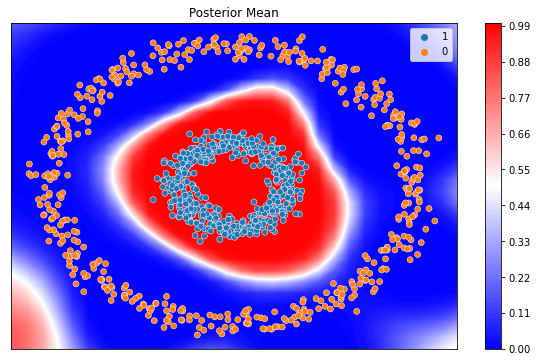

In [16]:
plot_pyro_predictions(mcmc_samples, x)